# Wind Farm Power Prediction

In [1]:
# load modules (install floris)
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gpflow
import GPy
import random
from pygmo import hypervolume

# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
%matplotlib inline

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

np.random.seed()

# Define Wind Farm Power Calculator
## inputs are:
floris object (that will be initiated with wind farm configuations, i.e., number of WT, locations)

wd (wind direction)

ws (wind speed)

yawAngle (action vector whose dimension is the number of wind turbines) 

In [2]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

# Compute the maximum wind turbine power using single wind turbine 

In [3]:
#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446


## Setup Wind Farm Layout
### Open "example_input_double.json" and look at how the wind farm is defined

In [4]:
floris = Floris("example_input_12.json")

# Compute the power vector and total wind farm power

In [5]:
wd=180;
ws=8;
num_tur = len(floris.farm.flow_field.turbine_map.items())
yawAngle = np.ones(num_tur)*0.01
power, totalPower = windFarmPower(floris, wd, 8, yawAngle, powerSingle)
totalPower

array([[0.50672764]])

# Compare the greedy control and cooperative control (optimized yaw angle vector)

In [6]:
def hypervolume_poi(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1

    # Calculate Hypervolume contribution of points Y
    ub_points = np.zeros((1, num_cells*outdim))
    lb_points = np.zeros((1, num_cells*outdim))
    for i in range(len(ub_idx)):
        ub_points[0,i] = pf_ext[ub_idx[i][0],ub_idx[i][1]]
        lb_points[0,i] = pf_ext[lb_idx[i][0],lb_idx[i][1]]
    ub_points = np.reshape(ub_points, [num_cells, outdim])
    lb_points = np.reshape(lb_points, [num_cells, outdim])

    splus_valid = np.all(np.tile(np.expand_dims(ub_points, 1), [1, N, 1]) > candidate_mean,
                                axis=2)  # num_cells x N
    splus_idx = np.expand_dims(splus_valid.astype(np.float64), -1)  # num_cells x N x 1
    splus_lb = np.tile(np.expand_dims(lb_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus_lb = np.maximum(splus_lb, candidate_mean)  # num_cells x N x outdim
    splus_ub = np.tile(np.expand_dims(ub_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus = np.concatenate([splus_idx, splus_ub - splus_lb], axis=2)  # num_cells x N x (outdim+1)
    Hv = np.transpose(np.sum(np.prod(splus, axis=2), axis=0, keepdims=True))  # N x 1
    
    # return HvPoI
    return -np.multiply(Hv, PoI)

def EHVI(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))

    ext1, ext2 = np.array([[-np.inf, reference[0][1]]]), np.array([[reference[0][0], -np.inf]])
    pf_ext = np.concatenate([ext1, pareto.front, ext2], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    normal1 = scipy.stats.norm(candidate_mean[:,0], np.sqrt(candidate_var[:,0]))
    normal2 = scipy.stats.norm(candidate_mean[:,1], np.sqrt(candidate_var[:,1]))
    
    P1 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    P2 = np.zeros((Xcand.shape[0], len(pareto.front)+1))
    
    for i in range(len(pareto.front)+1):
        if i == 0:
            P1[:,i] = 0
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)
        else:
            P1[:,i] = (pf_ext[i+1, 0] - pf_ext[i, 0]) * normal1.cdf(pf_ext[i, 0]) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2) 
            P2[:,i] = (exipsi(pf_ext[i+1, 0], pf_ext[i+1, 0], normal1) - exipsi(pf_ext[i+1, 0], pf_ext[i, 0], normal1)) * exipsi(pf_ext[i, 1], pf_ext[i, 1], normal2)

            
    return -np.sum(P1 + P2, axis = 1)[:,None]

def exipsi(a, b, normal):
    return normal.std() * normal.pdf(b) + (a-normal.mean()) * normal.cdf(b)

def POI(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1
    
    # return HvPoI
    return -PoI

In [7]:
def sample_next_point(acquisition, gp_model, bounds, pareto, reference, outdim, wind_dir, N_mc = 5000):
    """
    acquisition : acquisition function of Gaussian processes
    gp_model : gpflow Gaussian process model
    eval_y : evaluated y list in current state
    bounds : boundary of next point
    n_restarts : number of restarts for scipy.minimize
    
    return : next x    
    """
    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, pareto, reference, outdim, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0=points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, pareto, reference, outdim, wind_dir))
    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [8]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

In [9]:
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [10]:
co = np.arange(0, 30, 0.1)
ang = np.zeros(num_tur)
po = []
for i in co:
    pow1, totalp = windFarmPower(floris, i, 8, ang, powerSingle)
    po.append(totalp)
po = np.array(po).reshape((len(po), 1))

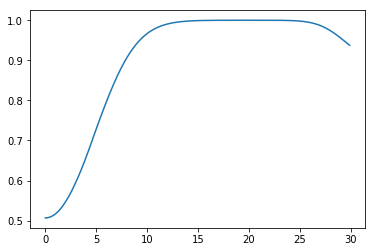

In [11]:
plt.plot(co, po)
plt.show()

In [12]:
test_c = np.random.uniform(0, 10)
# test_c = 0

In [13]:
# Generate context
def generate_context(lower, upper, length):
    con = [0]
    for i in range(length-1):
        prob = np.random.uniform(0,1)
        if prob >= 0.5:
            if con[-1] + 1 > upper:
                new_c = con[-1] - 1
            else:
                new_c = con[-1] + 1      
        else:
            if con[-1] - 1 < lower:
                new_c = con[-1] + 1      
            else:
                new_c = con[-1] - 1
        con.append(new_c)
    return np.array(con)[:,None]

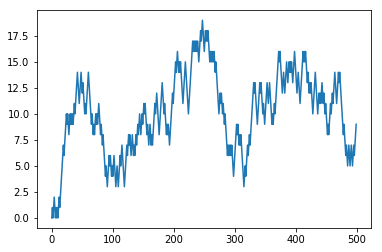

In [15]:
plt.plot(generate_context(0, 30, 500))
plt.show()

In [16]:
# initial data point of wind-farm
init_sample = 1
upper = 30
lower = 0
wd_init = generate_context(lower, upper, init_sample)

initial_input = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    initial_input[i,:] = yawangles
initial_input = np.hstack((initial_input, wd_init))
initial_output = multiobj_f(initial_input)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


In [17]:
num_iter = 300
wd_context = generate_context(lower, upper, num_iter)
cmbo_input = initial_input
cmbo_output = initial_output
num_output = cmbo_output.shape[1]


for i in range(num_iter):
    if i % 3 == 0:
        wd_context[i] = test_c

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(cmbo_input.copy(), cmbo_output[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(cmbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([cmbo_input[j] for j in range(len(cmbo_input)) if wd_context[i]-30 <= cmbo_input[j,-1] <= wd_context[i]+30])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    cmbo_input = np.append(cmbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_output = np.append(cmbo_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


In [22]:
cmbo_input

array([[14.29994259,  2.76904796,  2.68088915, ..., 12.69465173,
         2.75368387,  0.        ],
       [ 1.13645736,  6.32608248,  8.26999581, ..., 13.61402926,
        20.68739699,  5.        ],
       [21.58579892,  3.20846975, 16.88641557, ...,  3.46962083,
        13.1780713 ,  1.        ],
       ...,
       [21.64354272,  8.17646536, 20.93494352, ..., 21.10284315,
         8.86178235,  5.        ],
       [ 2.2569235 , 12.45263701,  0.37248877, ..., 20.18930651,
         3.34406989,  0.        ],
       [17.67021281,  0.33590286,  3.62653234, ..., 24.88470001,
        23.80522395,  1.        ]])

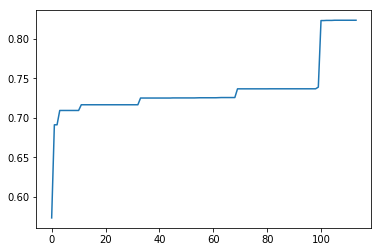

In [24]:
target_index = [i for i in range(len(cmbo_input)) if cmbo_input[i][-1] == 5]
volume2 = []
ref_point = [0,1]
for i in range(len(cmbo_output[target_index])):
    hv = hypervolume(cmbo_output[target_index][:i+1])
    v = hv.compute(ref_point)
    volume2.append(v)
plt.plot(volume2)
plt.show()

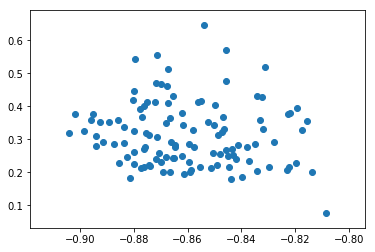

In [25]:
plt.scatter(cmbo_output[target_index][:,0], cmbo_output[target_index][:,1])
plt.show()

In [19]:
num_iter = 100
mbo_input = initial_input
mbo_output = initial_output

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(mbo_input.copy(), mbo_output[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params-1, ARD=True)) for i in range(mbo_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    pareto.update(mbo_output)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, test_c))
    next_point = np.hstack((next_point, np.ones((1,1)) * test_c))
    mbo_input = np.append(mbo_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    mbo_output = np.append(mbo_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 12 then the given X dimension 13. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


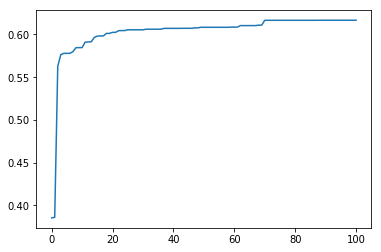

In [20]:
volume3 = []
ref_point = [0,1]
for i in range(len(mbo_output)):
    hv = hypervolume(mbo_output[:i+1])
    v = hv.compute(ref_point)
    volume3.append(v)
plt.plot(volume3)
plt.show()

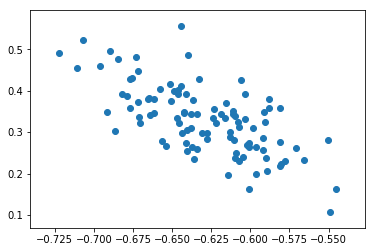

In [21]:
plt.scatter(mbo_output[:,0], mbo_output[:,1])
plt.show()

In [22]:
uniform_input = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(100, bounds.shape[0]))
uniform_input = np.vstack((initial_input,np.hstack((uniform_input, np.zeros((100,1))))))
uniform_output = multiobj_f(np.atleast_2d(uniform_input))

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


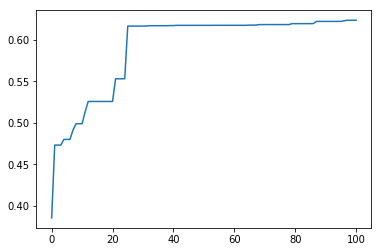

In [23]:
volume4 = []
ref_point = [0,1]
for i in range(len(uniform_output)):
    hv = hypervolume(uniform_output[:i+1])
    v = hv.compute(ref_point)
    volume4.append(v)
plt.plot(volume4)
plt.show()

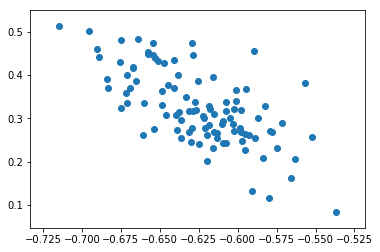

In [24]:
plt.scatter(uniform_output[:,0], uniform_output[:,1])
plt.show()

In [25]:
def ls_f(yawangle):
    Y = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y[i] = -totalPower/2 + np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur / 2
    return Y

def expected_improvement(Xcand, gp_model, current_min, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    mu, var = gp_model.predict(Xcand)
    sigma = np.sqrt(var)
    
    Z = (current_min - mu) / sigma
    ei = (current_min - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return -ei[0]

def single_next_point(acquisition, gp_model, bounds, eval_y, wind_dir, N_mc = 5000):

    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    current_min = np.min(eval_y)
    # Random 한 점을 많이 찍고 그 중 가장 acquisition ftn value가 높은 지점을 start 지점으로 삼아 scipy minimize 함수 작동
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, current_min, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0 = points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, current_min, wind_dir))

    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

lin_input = np.atleast_2d(initial_input)
lin_output = ls_f(lin_input) 


for i in range(num_iter):
    gp_model = GPy.models.GPRegression(lin_input.copy(), lin_output.copy(), kernel= GPy.kern.Matern52(input_dim=n_params-1, ARD=True))
    gp_model.optimize()
    
    next_point = np.atleast_2d(single_next_point(expected_improvement, gp_model, bounds, lin_output, test_c))
    next_point = np.hstack((next_point, np.ones((1,1)) * test_c))
    lin_input = np.append(lin_input, next_point, axis = 0)
    function_value = ls_f(np.atleast_2d(next_point))
    lin_output = np.append(lin_output, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 12 then the given X dimension 13. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt


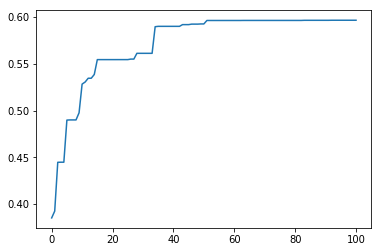

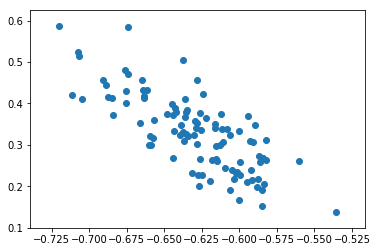

In [26]:
lin_output = multiobj_f(np.atleast_2d(lin_input))
volume5 = []
ref_point = [0,1]
for i in range(len(lin_output)):
    hv = hypervolume(lin_output[:i+1])
    v = hv.compute(ref_point)
    volume5.append(v)
plt.plot(volume5)
plt.show()

plt.scatter(lin_output[:,0], lin_output[:,1])
plt.show()

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract


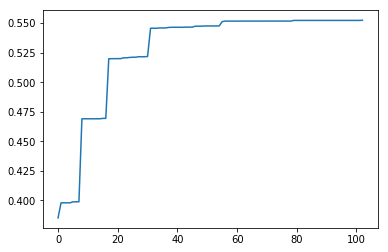

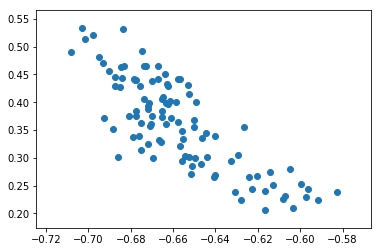

In [27]:
cmbo_EHVI_input = initial_input
cmbo_EHVI_output = initial_output
num_iter = 300

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(cmbo_EHVI_input.copy(), cmbo_EHVI_output[:,[i]].copy(), 
                                         kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(cmbo_EHVI_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([cmbo_EHVI_input[j] for j in range(len(cmbo_EHVI_input)) if wd_context[i]-30 <= cmbo_EHVI_input[j,-1] <= wd_context[i]+30])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(EHVI, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    cmbo_EHVI_input = np.append(cmbo_EHVI_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_EHVI_output = np.append(cmbo_EHVI_output, function_value, axis = 0)
    
volume6 = []
ref_point = [0,1]
for i in range(len(cmbo_EHVI_output[target_index])):
    hv = hypervolume(cmbo_EHVI_output[target_index][:i+1])
    v = hv.compute(ref_point)
    volume6.append(v)
plt.plot(volume6)
plt.show()

plt.scatter(cmbo_EHVI_output[target_index][:,0], cmbo_EHVI_output[target_index][:,1])
plt.show()

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary

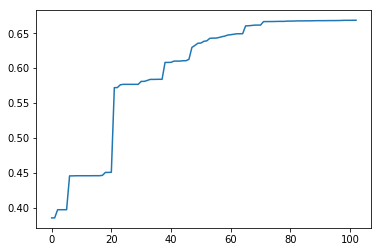

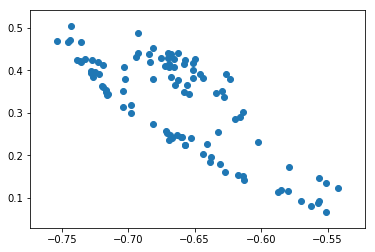

In [28]:
cmbo_POI_input = initial_input
cmbo_POI_output = initial_output

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(cmbo_POI_input.copy(), cmbo_POI_output[:,[i]].copy(), 
                                         kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(cmbo_POI_output.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([cmbo_POI_input[j] for j in range(len(cmbo_POI_input)) if wd_context[i]-30 <= cmbo_POI_input[j,-1] <= wd_context[i]+30])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(POI, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    cmbo_POI_input = np.append(cmbo_POI_input, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    cmbo_POI_output = np.append(cmbo_POI_output, function_value, axis = 0)
    
volume7 = []
ref_point = [0,1]
for i in range(len(cmbo_POI_output[target_index])):
    hv = hypervolume(cmbo_POI_output[target_index][:i+1])
    v = hv.compute(ref_point)
    volume7.append(v)
plt.plot(volume7)
plt.show()

plt.scatter(cmbo_POI_output[target_index][:,0], cmbo_POI_output[target_index][:,1])
plt.show()

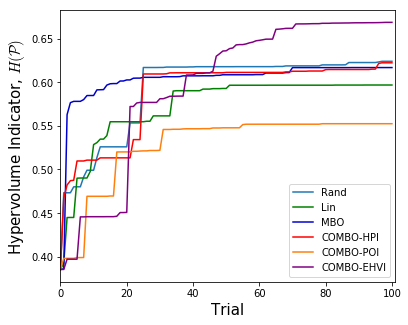

In [29]:
plt.figure(figsize=(6,5))
plt.xlim([0, 101])
plt.xlabel('Trial', fontsize = 15)
plt.ylabel(r'Hypervolume Indicator, $H(\mathcal{P})$', fontsize = 15)
plt.plot(volume4, label = 'Rand')
plt.plot(volume5, label = 'Lin', color = 'green')
plt.plot(volume3, label = 'MBO', color = 'mediumblue')
plt.plot(volume2[:101], label = 'COMBO-HPI', color = 'red')
plt.plot(volume6[:101], label = 'COMBO-POI')
plt.plot(volume7[:101], label = 'COMBO-EHVI', color = 'purple')
plt.legend(loc = 4)


plt.savefig('turbine_16.png',bbox_inches='tight')
plt.show()

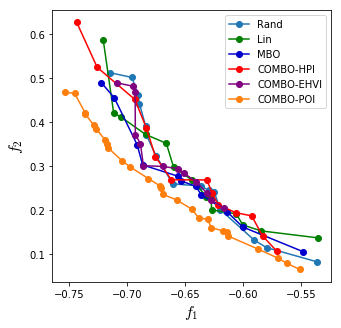

In [30]:
pareto = Pareto(np.empty((0, num_output)))
pareto.update(uniform_output)
uni_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(lin_output)
lin_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(mbo_output)
mbo_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(cmbo_output[target_index][:101])
cmbo_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(cmbo_EHVI_output[target_index][:101])
cmbo_EHVI_pf = pareto.front

pareto = Pareto(np.empty((0, num_output)))
pareto.update(cmbo_POI_output[target_index][:101])
cmbo_POI_pf = pareto.front

plt.figure(figsize=(5,5))
plt.xlabel(r'$f_{1}$', fontsize = 16)
plt.ylabel(r'$f_{2}$', fontsize = 16)

#plt.scatter(uni_pf[:,0], uni_pf[:,1], label = 'Rand', facecolors='none')
plt.plot(uni_pf[:,0], uni_pf[:,1], '-o', label = 'Rand')
plt.plot(lin_pf[:,0], lin_pf[:,1], '-o', label = 'Lin', c='green')
plt.plot(mbo_pf[:,0], mbo_pf[:,1], '-o', label = 'MBO', c='mediumblue')
plt.plot(cmbo_pf[:,0], cmbo_pf[:,1], '-o', label = 'COMBO-HPI', c='red')
plt.plot(cmbo_EHVI_pf[:,0], cmbo_EHVI_pf[:,1], '-o', label = 'COMBO-EHVI', color = 'purple')
plt.plot(cmbo_POI_pf[:,0], cmbo_POI_pf[:,1], '-o', label = 'COMBO-POI')
plt.legend(loc=1)
plt.savefig('turbine_16_pareto.png',bbox_inches='tight')
plt.show()

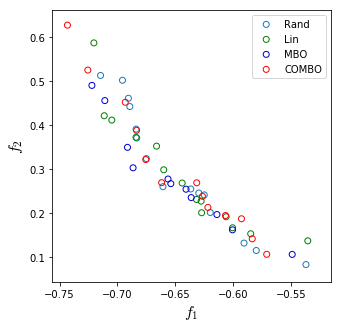

In [31]:
plt.figure(figsize=(5,5))
plt.xlabel(r'$f_{1}$', fontsize = 16)
plt.ylabel(r'$f_{2}$', fontsize = 16)

plt.scatter(uni_pf[:,0], uni_pf[:,1], label = 'Rand', facecolors='none', color='#1f77b4')
plt.scatter(lin_pf[:,0], lin_pf[:,1], label = 'Lin', facecolors='none', color='green')
plt.scatter(mbo_pf[:,0], mbo_pf[:,1], label = 'MBO', facecolors='none', color='mediumblue')
plt.scatter(cmbo_pf[:,0], cmbo_pf[:,1], label = 'COMBO', facecolors='none', color='red')
plt.legend(loc=1)
plt.show()